In [6]:
import impaintingLib as imp
import re

from torch.utils.tensorboard import SummaryWriter
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def modelMatch(model,in_channels):
    
    if "autoenco" in model :
        res = imp.model.AutoEncoder(in_channels).to(device)
        
    elif "unet" in model :
        convType = "conv2d"
        netType  = "default"
        
        if "dilat" in model :
            convType = "dilated"
        if "gate" in model :
            convType = "gated"
        if "partial" in model :
            netType  = "partial"
            
        res = imp.model.UNet(in_channels, convType=convType, netType=netType).to(device)
        
    elif "pixel" in model :
        res = imp.model.SubPixelNetwork(in_channels).to(device)
        
    else :
        print("ERREUR : AUCUN MODELE RECONNUE DANS {}".format(model))
        
    return res

def lossMatch(loss):
    
    if "l1" in loss :
        res = torch.nn.L1Loss()
    elif "l2" in loss :
        res = torch.nn.MSELoss()
    elif "vgg" in loss :
        res = imp.loss.perceptualVGG
    elif "ae" in loss :
        res = imp.loss.perceptualAE
    elif "classif" in loss :
        res = imp.loss.perceptualClassifier
    elif "totalvar" in loss :
        res = imp.loss.totalVariation
        
    else :
        print("ERREUR : AUCUNE LOSS RECONNUE DANS {}".format(loss))
        
    return res

def parse(expeName = 'basic'):

    count = 0
    path = "./routines/" + expeName + ".txt"
    doSave = False
    onlyTest = False
    doRetrain = False
    indiv = False
    classify = False
    resize = 1
    
    # Si seed = 0 alors on est random sinon on est "déterministe"
    seed = 0
    runsRegex = r"model=(\S+,{0,1})+ loss=(\S+,{0,1})+"
    
    with open(path) as file:
        lines = file.readlines()
        
    # première ligne = paramètres
    paramLine = lines.pop(0)
    lineSplit = paramLine.strip().split(",")
    epoch = int(lineSplit[0])

    if "save" in lineSplit:
        doSave = True
    if "test" in lineSplit:
        onlyTest = True
    if "seed" in lineSplit:
        seed = 1
    if "retrain" in lineSplit:
        doRetrain = True
    if "classify" in lineSplit:
        classify = True
    if "indiv" in lineSplit:
        indiv = True
        
    if "medium" in lineSplit:
        resize = 2
    if "large" in lineSplit:
        resize = 3
    if "xl" in lineSplit:
        resize = 4

    shuffle = seed == 0
    trainloader, testloader = imp.data.getFaces(shuffle=shuffle,resize=resize)
    if not shuffle :
        torch.manual_seed(seed)
    
    # Reste du fichiers
    for i,line in enumerate(lines):
        line = line.strip()

        # autres lignes = scenario
        if line and line[0] != "#" :
            model_list,loss_list = re.search(runsRegex, line).groups()
            model_list = model_list.split(",")
            loss_list  = loss_list.split(",")
            
            losses = []
            for loss in loss_list :
                loss = loss.split("*")
                if len(loss) < 2 :
                    loss = ["1"] + loss
                    
                loss[0] = int(loss[0])
                loss[1] = lossMatch(loss[1].lower())
                losses.append(loss)
                
            models = []
            if classify :
                first_model = model_list.pop(0).lower()
                models.append(modelMatch(first_model,4)) # Le premier model prend 4 channels en input
            models += [modelMatch(model.lower(),3) for model in model_list] # Les autres en prennent 3
            
            runName = "{} {}".format("-".join(map(str, models)), " + ".join(loss_list))
            optimizer  = torch.optim.Adam(models[-1].parameters(), lr=1e-3, weight_decay=0.001)
            visu       = imp.utils.Visu(runName = runName, expeName=expeName, save=doSave, gridSize =8)
            
            print("------ Scénario {} : {}".format(count,runName))
            count += 1
            concatRunName = expeName + "_" + runName
            alterFunc = imp.mask.Alter(min_cut=15*3, max_cut=45*3, seed=seed, resize=resize).irregularMask #.irregularMask #.downScale #.squareMask
            
            # Train
            if not onlyTest : 
                print("- Train")
                visuFuncs = [#visu.board_loss_train,
                             #visu.plot_altered_img,
                             #visu.plot_res_img
                ]
                
                if doRetrain : 
                    models = imp.process.model_load(models,concatRunName)
                
                elif not indiv :
                    
                    if "gated" in line : 
                        models[0].load_state_dict(torch.load('modelSave/partialgated_3channels.pth')) 
                    else : 
                        models[0].load_state_dict(torch.load('modelSave/partial_3channels.pth')) 
                    models[1].load_state_dict(torch.load('modelSave/pixelshuffle_3channels.pth'))
                
                imp.process.train(models, optimizer, trainloader, losses, epochs=epoch, alter=alterFunc, visuFuncs=visuFuncs, classify=classify)

                if doSave:
                    imp.process.model_save(models,concatRunName)
            
            # Test
            if onlyTest : 
                models = imp.process.model_load(models,concatRunName)
            
            print("- Test")
            
            visuFuncs = [#visu.board_loss_test,
                         #visu.board_plot_img,
                         visu.plot_original_img,
                         visu.plot_altered_img,
                         visu.plot_res_img
                        ]
            imp.process.test(models, testloader, alter=alterFunc, visuFuncs=visuFuncs, classify=classify)

------ Scénario 0 : UNet(partial conv2d) L1 + 500*perceptualAE + perceptualVGG + totalvar
- Test


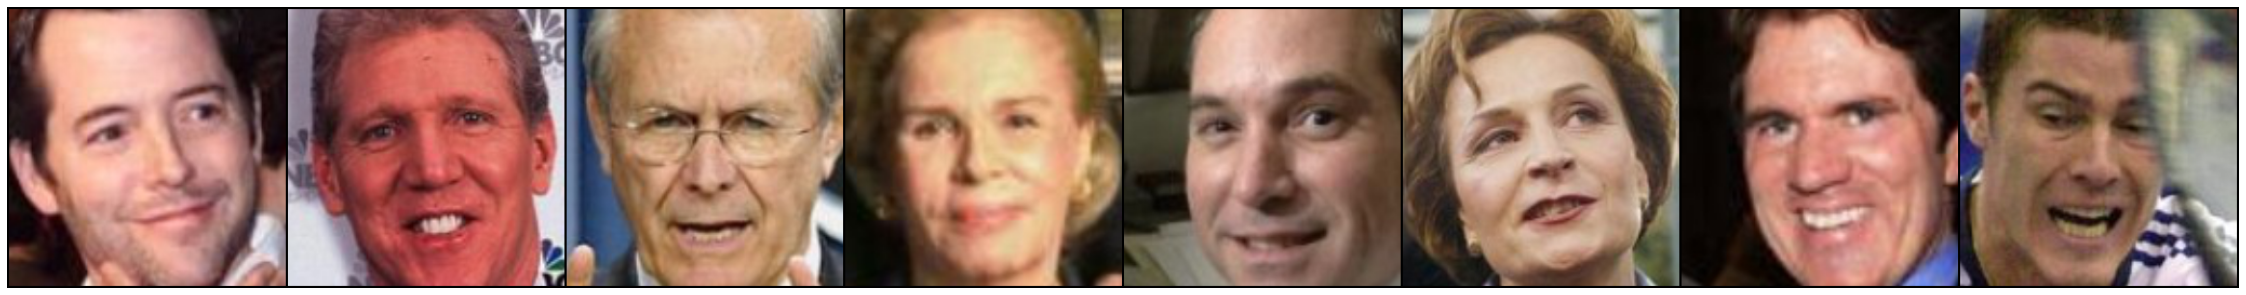

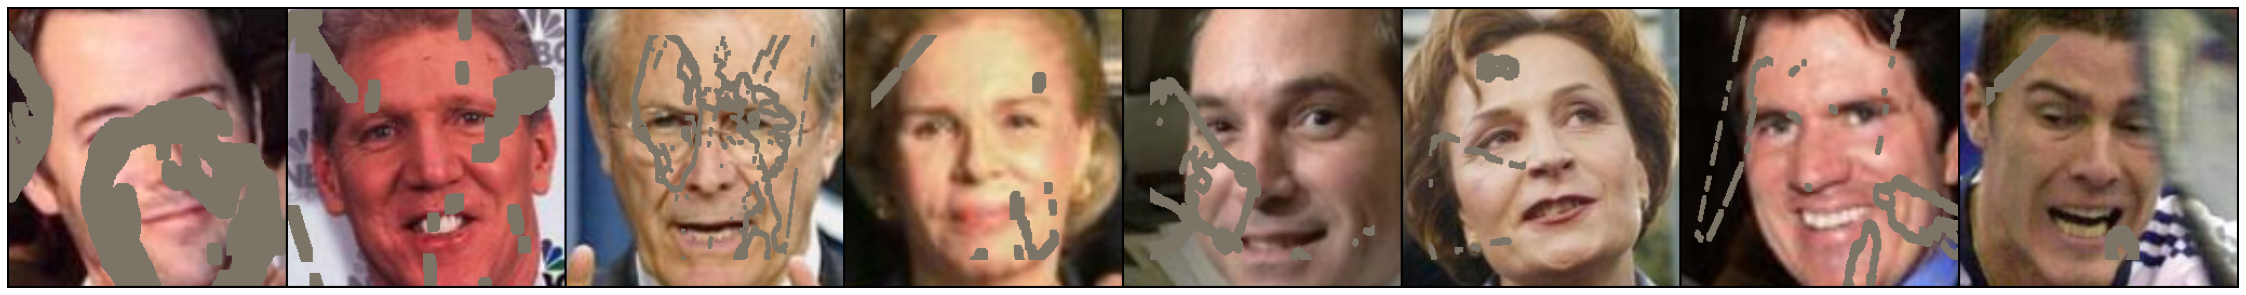

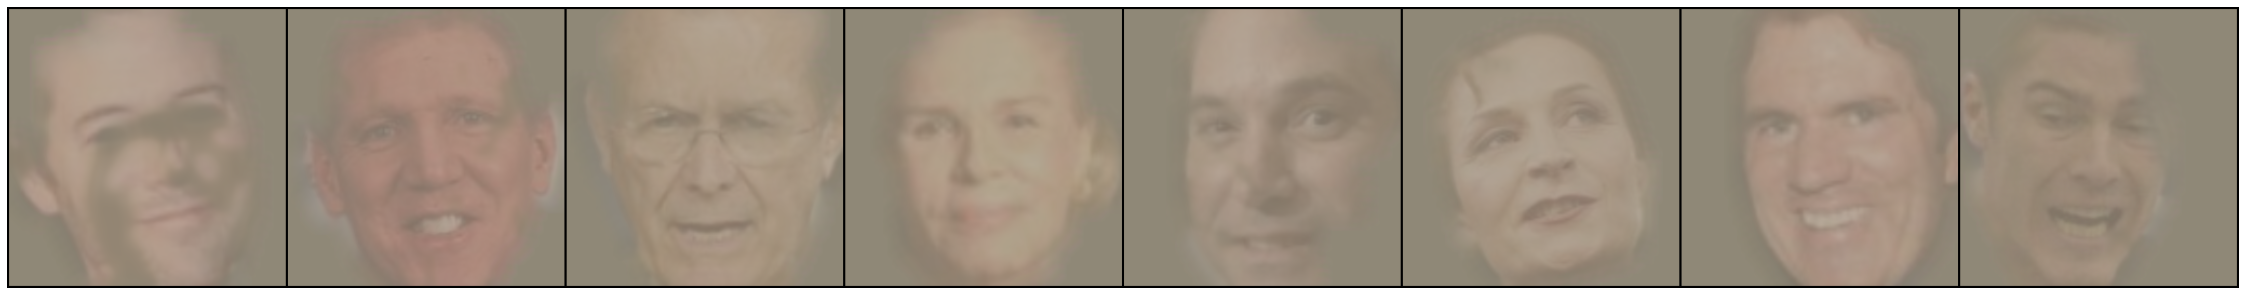

In [7]:
# best_sizeup gated_conv gatedAugment perceptualClassifier trainPartialClassify
parse("trainPartialClassify")